# Python Outlier Detection (PyOD) Autoencoder

- Environment: Python 3.6
- Installation: [PyOD](https://github.com/yzhao062/pyod)
- pip install combo
- You can find all the algorithms of PyOD [here](https://pyod.readthedocs.io/en/latest/) and [here](https://pyod.readthedocs.io/en/latest/pyod.html).
**Learning Objectives:**
- Understand PyOD
- Use autoencoder to build three models: clf1, clf2, clf3
- Combination Methods
**Assignment:**
- Please select two algorithms to apply to your dataset.
- Your analysis should provide a clear description for each of the algorithm and the results.
- Your work should perform the combination methods.
- Justify your identification for the anomalies with the data attributes.
**First, we generate a dataframe with outliers**
- There are total 500 obsservations including 10%, or 50, outliers
- In your assignment, split your dataset to be X_train and X_test. Then you can follow accordingly.
- We do not use the iris dataset because it only has 4 variables. We build a large dataset with 25 variables in order to show the power of neural network.

In [136]:
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
#!pip install combo

In [153]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
#from pyod.utils.data import evaluate_print
#from pyod.utils.example import visualize

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)


X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [154]:
#When you do unsupervised learning, it is always a safe step to standardize the predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)    # Only the training data are used to fit the scaler transformation,
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)  # then the scaler is used to transform the test input data.
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

### Plot in a 2-D space

In [111]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()

,PC1,PC2
0,-3.054514,-0.744309
1,-2.514871,1.555876
2,-3.545867,-0.568265
3,-3.742949,-0.461278
4,-2.394277,0.338002


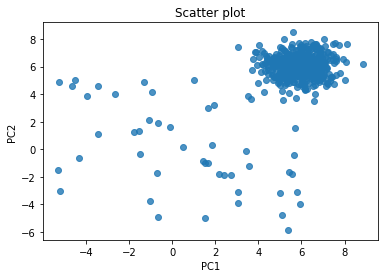

In [112]:
# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], alpha=0.8) 
plt.title('Scatter plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Autoencoder
* You do not need the target variable to train the unsupervised learning model.
* We will build three models: clf1, clf2, and clf3
* clf1 has hidden_neurons = [25, 2, 2, 25]
* clf2 has hidden_neurons = [25, 10, 2, 10, 25]
* clf3 has hidden_neurons = [25, 15, 10, 2, 10, 15, 25])
* The number of the hidden layers and the number of neutrons in a hidden layer: if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit.

#### Model 1

In [113]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train_scaled)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_12 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_13 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f8b33577d90>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

#### Learn how to produce outlier scores
* "decision_functions()" predicts the outliers of a dataframe. A higher score means more abnormal. 
* The histogram below shows there are outliers. If we choose 1.0 to be the cutpoint, we can suggest those >=1.0 to be outliers

In [114]:
y_train_scores = clf1.decision_scores_ 
#y_train_scores

In [115]:
y_train_scores = clf1.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf1.predict(X_test_scaled)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test_scaled)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

In [116]:
y_test_pred.value_counts()

0    450
1     50
dtype: int64

In [117]:
y_test_scores

0       2.586388
1       2.181094
2       2.175470
3       2.155936
4       2.028136
         ...    
495    14.358992
496    15.885574
497    14.023825
498    13.999738
499    15.740541
Length: 500, dtype: float64

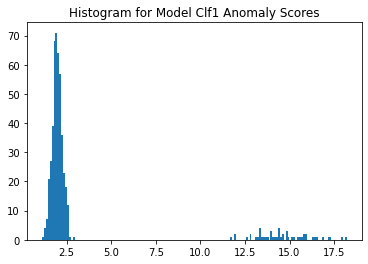

In [118]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

* We will identify the outliers as a cluster and demonstrate the X attributes

In [120]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    450
1     50
Name: cluster, dtype: int64

#### Describe the outliers
* We recommend observations in Cluster 1 to be outliers. 
* The attributes of Cluster 1 are shown below.

In [121]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.284756,0.233752,0.213252,0.282784,0.304749,0.268499,0.256723,0.330233,0.307315,0.264452,...,0.274579,0.268014,0.261233,0.300980,0.257770,0.306561,0.246576,0.235519,0.266344,1.968473
1,-2.405669,-2.351177,-2.171415,-1.715717,-2.212427,-2.263555,-2.649875,-2.384148,-2.375294,-2.013565,...,-2.580048,-2.536069,-2.122499,-2.475651,-2.708152,-3.006297,-2.566102,-2.784837,-2.326757,14.613177


#### Model 2

In [155]:
clf2 = AutoEncoder(hidden_neurons =[25, 10,2, 10, 25])
clf2.fit(X_train_scaled)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test_scaled)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_64 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_65 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_66 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 10)               

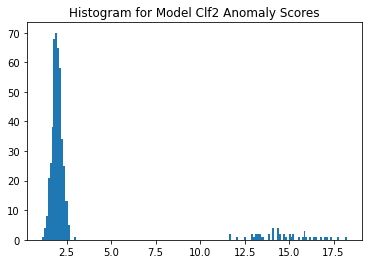

In [156]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [150]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    450
1     50
Name: cluster, dtype: int64

In [151]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.713394
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.503675


In [ ]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

#### Model 3

In [130]:
clf3 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf3.fit(X_train_scaled)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test_scaled)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_41 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_42 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_43 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 15)               

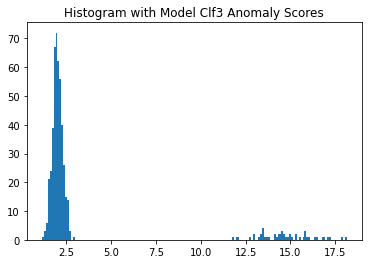

In [131]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [157]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.284756,0.233752,0.213252,0.282784,0.304749,0.268499,0.256723,0.330233,0.307315,0.264452,...,0.274579,0.268014,0.261233,0.300980,0.257770,0.306561,0.246576,0.235519,0.266344,1.953432
1,-2.405669,-2.351177,-2.171415,-1.715717,-2.212427,-2.263555,-2.649875,-2.384148,-2.375294,-2.013565,...,-2.580048,-2.536069,-2.122499,-2.475651,-2.708152,-3.006297,-2.566102,-2.784837,-2.326757,14.650185


In [197]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.717365
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.492314


## Achieve Model Stability by Aggregating Multiple Models
* Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
* The solution is to train multiple models then aggregate the scores. 
* There are four methods to aggregate the outcome:
* (1) Average: average scores of all detectors.
* (2) Maximum of Maximum (MOM)
* (3) Average of Maximum (AOM)
* (4) Maximum of Average (MOA)

In [137]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test_scaled),
                             'clf2': clf2.decision_function(X_test_scaled),
                             'clf3': clf3.decision_function(X_test_scaled) 
                            })

In [138]:
train_scores.head()

,clf1,clf2,clf3
0,1.957072,1.982249,2.000097
1,1.790600,1.808246,1.818738
2,2.198084,2.227000,2.236369
3,2.143363,2.176961,2.189760
4,1.920019,1.932912,1.947401


In [139]:
test_scores.head()

,clf1,clf2,clf3
0,2.586388,2.608600,2.621929
1,2.181094,2.210545,2.213401
2,2.175470,2.178704,2.201436
3,2.155936,2.191460,2.212148
4,2.028136,2.053246,2.065866


In [141]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
from pyod.utils.utility import standardizer
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [142]:
train_scores_norm.shape

(500, 3)

### Average
The "average" function in PyOD averages the outlier scores from multiple estimators.
See [PyOD API Reference](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn).

In [143]:
# Combination by average
y_by_average = average(test_scores_norm)
y_by_average[1:10]

array([-0.28345056, -0.28780256, -0.28746368, -0.32380907, -0.32975648,
       -0.32898645, -0.37262915, -0.25824893, -0.27185412])

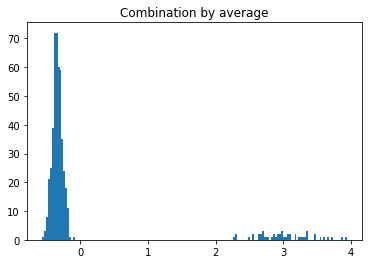

In [144]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >=0.0 as the outliers

In [145]:
df_test = pd.DataFrame(X_test_scaled)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    450
1     50
Name: y_by_average_cluster, dtype: int64

#### Describe the outliers

In [146]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.284756,0.233752,0.213252,0.282784,0.304749,0.268499,0.256723,0.330233,0.307315,0.264452,...,0.274579,0.268014,0.261233,0.300980,0.257770,0.306561,0.246576,0.235519,0.266344,-0.339979
1,-2.405669,-2.351177,-2.171415,-1.715717,-2.212427,-2.263555,-2.649875,-2.384148,-2.375294,-2.013565,...,-2.580048,-2.536069,-2.122499,-2.475651,-2.708152,-3.006297,-2.566102,-2.784837,-2.326757,3.014735


### Maximum of maximum
Merge the outlier scores from multiple estimators by taking the maximum.

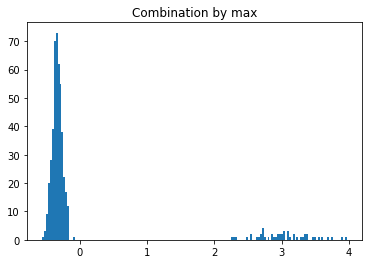

In [147]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

Similarly, it appears we can identify those >=0.0 as the outliers

In [148]:
df_test = X_test_scaled.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    450
1     50
Name: y_by_maximization_cluster, dtype: int64

#### Describe the outliers

In [149]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.284756,0.233752,0.213252,0.282784,0.304749,0.268499,0.256723,0.330233,0.307315,0.264452,...,0.261233,0.300980,0.257770,0.306561,0.246576,0.235519,0.266344,-0.339979,0,-0.338286
1,-2.405669,-2.351177,-2.171415,-1.715717,-2.212427,-2.263555,-2.649875,-2.384148,-2.375294,-2.013565,...,-2.122499,-2.475651,-2.708152,-3.006297,-2.566102,-2.784837,-2.326757,3.014735,1,3.027822
